In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import re

ruta_csv = "./CSVDATABASE.csv"

df = pd.read_csv(ruta_csv, encoding="Windows-1252", sep=";", parse_dates=True)

useless_columns = ['Id', 'Language','        Heu llegit tota la informació que se us ha facilitat sobre aquest projecte i accepteu participar-hi?      ','Hora de inicio','Hora de finalización', 'Correo electrónico', 'Nombre']
cols_to_drop = [c for c in useless_columns if c in df.columns]
if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)
else:
    print("No matching columns to drop.")


# ============================================================
# LIMPIEZA PREVIA DE COLUMNAS: eliminar "Resposta", espacios,
# unicode raro, y dejar las Likert terminando en "." limpio
# ============================================================

clean_cols = []

for col in df.columns:
    new = col

    # 1. Normalizar espacios (colapsar espacios múltiples)
    new = " ".join(new.split())

    # 2. Limpiar caracteres invisibles
    new = new.replace("\xa0", " ")
    new = new.replace("\x92", "'")
    new = new.replace("\n", " ")

    # 3. Si contiene "Resposta", eliminarlo por completo
    if "Resposta" in new:
        # Eliminar todo lo que aparezca después de la primera oración
        # Ejemplo: "xxx. .Resposta" → "xxx."
        new = new.split(".")[0].strip() + "."

    clean_cols.append(new)

df.columns = clean_cols


#MAPPING DE LES PREGUNTES

column_map = {
    "Edat en anys en el moment de l'enquesta": "edat",
    "Sexe assignat al néixer": "sexe_assignat",
    "Gènere": "genere",
    "País de naixement": "pais_naixement",
    "Curs acadèmic actual": "curs",
    "Assignació mensual aproximada en euros (diners dels que disposes mensualment)": "assignacio_mensual",
    
    "Quin tipus de substàncies has consumit en els darrers 30 dies? (pots marcar més d’una)": "subs_30dies",
    "Coneixes la diferència entre els productes de tabac per escalfament (tipus IQOS) i les cigarretes electròniques (vàpers)?": "coneix_diferencia_iqos_vaper",
    "Quina és la teva història de fumador/a? (Qualsevol   tipus de consum, inclòs el tabac convencional, cigarreta electrònica i altres   productes de tabac)       ": "historia_fumador",
    
    "Quants minuts després de despertar-te fumes la primera cigarreta?      \n": "primera_cigarreta_minuts",
    "Quantes cigarretes fumes al dia?      ": "cigarretes_dia",
    "En quins àmbits consumeixes habitualment? (pots marcar més d’una opció)": "ambits_consum",
    
    "A quina edat vas començar a fumar cigarretes convencionals? (Si no n'has fumat escriu \"mai\")": "edat_inici_conventional",
    "A quina edat vas començar a consumir cigarretes electròniques (vàper)? (Si no n'has fumat escriu \"mai\")": "edat_inici_vaper",
    "A quina edat vas començar a consumir IQOS (tabac escalfat)? (Si no n'has fumat escriu \"mai\")": "edat_inici_iqos",
    
    "Quin va ser el motiu principal per començar a consumir cigarretes electròniques (vàper)? (pots marcar més d'una)      ": "motiu_inici_vaper",
    "Quin va ser el motiu principal per començar a consumir IQOS (tabac escalfat)? (pots marcar més d'una)      ": "motiu_inici_iqos",

    "Les dues persones amb qui tens més relació a la universitat fumen o vapegen?      ": "amics_fumen",
    "Aquestes persones...?      ": "influencia_amics",

    # ---- Escala Likert ----
    "Les cigarretes electròniques són fàcils d’adquirir.": 
        "likert_facil_adquirir",

    "El seu preu és assequible per a la majoria dels joves.": 
        "likert_preu_assequible",

    "Vapejar està socialment ben vist.": 
        "likert_social",

    "Considero que és normal veure companys vapejant en espais universitaris o socials.": 
        "likert_normal_vapejar",

    "Crec que les cigarretes electròniques són segures per a la salut.": 
        "likert_seguretat",

    "Les considero menys perjudicials que el tabac convencional.": 
        "likert_menys_perjudicials",

    "No hi ha prou estudis sobre els efectes adversos del vaping.": 
        "likert_pocs_estudis",

    "El vapor de les cigarretes electròniques no afecta a tercers.": 
        "likert_no_afecta_tercers",

    "S’hauria de limitar l’accés a menors.": 
        "likert_limit_menors",

    "Caldria un control més estricte de la seva venta.": 
        "likert_control_estricte",

    "Els sabors haurien d’estar regulats.": 
        "likert_regulacio_sabors",

    "Haurien d’estar prohibits en espais tancats.": 
        "likert_prohibicio_espais_tancats",

    "S’hauria de prohibir la seva publicitat en xarxes socials.": 
        "likert_prohibicio_publicitat",

    "Només s’haurien de vendre en punts autoritzats.": 
        "likert_punts_autoritzats",

    "Haurien de portar advertències sanitàries com el tabac.": 
        "likert_advertencies",

    "Les cigarretes electròniques poden portar a fumar cigarretes convencionals.": 
        "likert_electronic_induccio_tabac"
}

df.rename(columns=column_map, inplace=True)

# Normalización extra para columnas con "mai"
corr_map = {
    col: "edat_inici_vaper" 
    for col in df.columns 
    if "a quina edat vas començar a consumir cigarretes electròniques" in col.lower()
}

corr_map.update({
    col: "influencia_amics" 
    for col in df.columns 
    if "aquestes persones..." in col.lower()
})

corr_map.update({
    col: "cigarretes_dia" 
    for col in df.columns 
    if "quantes cigarretes fumes al dia" in col.lower()
})

corr_map.update({
    col: "amics_fumen" 
    for col in df.columns 
    if "les dues persones amb qui tens més relació a la universitat fumen o vapegen?" in col.lower()
})

corr_map.update({
    col: "edat_inici_iqos" 
    for col in df.columns 
    if "quina edat vas començar a consumir IQOS (tabac escalfat)" in col.lower()
})

corr_map.update({
    col: "primera_cigarreta_minuts" 
    for col in df.columns 
    if "minuts després de despertar-te fumes la primera cigarreta" in col.lower()
})

corr_map.update({
    col: "historia_fumador" 
    for col in df.columns 
    if "uina és la teva història de fumador" in col.lower()
})

corr_map.update({
    col: "motiu_inici_vaper" 
    for col in df.columns 
    if "uin va ser el motiu principal per començar a consumir cigarretes electròniques" in col.lower()
})

corr_map.update({
    col: "motiu_inici_iqos" 
    for col in df.columns 
    if "motiu principal per començar a consumir iqos" in col.lower()
})


df = df.rename(columns=corr_map)

likert_map = {
    "totalment en desacord": 1,
    "totalment en desacord": 1,
    "        totalment en desacord": 1,
    "en desacord ": 2,
    "en desacord": 2,
    "en desacord ": 2,
    "ni d’acord ni en desacord ": 3,
    "ni d’acord ni en desacord": 3,
    "ni d'acord ni en desacord": 3,
    "d’acord": 4,
    "d'acord": 4,
    "totalment d’acord": 5,
    "totalment d'acord": 5,
    "totalment d’acord": 5
}

likert_columns = [
 'likert_facil_adquirir',
 'likert_preu_assequible',
 'likert_social',
 'likert_normal_vapejar',
 'likert_seguretat',
 'likert_menys_perjudicials',
 'likert_pocs_estudis',
 'likert_no_afecta_tercers',
 'likert_limit_menors',
 'likert_control_estricte',
 'likert_regulacio_sabors',
 'likert_prohibicio_espais_tancats',
 'likert_prohibicio_publicitat',
 'likert_punts_autoritzats',
 'likert_advertencies',
 'likert_electronic_induccio_tabac'
]

for col in likert_columns:
    if col in df.columns:
        df[col] = df[col].map(likert_map)

def clean_assignacio(value):

    if pd.isna(value):
        return np.nan
    
    text = str(value).strip().lower()

    # --- CASOS QUE SON CERO ---
    zero_patterns = [
        "no em donen cap assignació",
        "no tinc una quantitat definida",
        "no treballo",
        "no",
        "pares paguen",
        "visc amb els meus pares", 
        "0", "0€", "0 euros", "0.0"
    ]
    for z in zero_patterns:
        if text.startswith(z):
            return 0

    # --- ELIMINAR SIMBOLOS Y ESPACIOS ---
    text = text.replace("€", "").replace("euros", "").replace("euro", "").strip()

    # --- RANGOS  ej: 90-100, 200-400 ---
    range_match = re.match(r"(\d+)\s*-\s*(\d+)", text)
    if range_match:
        low = int(range_match.group(1))
        high = int(range_match.group(2))
        return (low + high) / 2  # media del rango

    # --- NÚMEROS PUROS ---
    num_match = re.findall(r"\d+", text)
    if num_match:
        return float(num_match[0])

    # --- CASO NO INTERPRETABLE ---
    return np.nan

preguntes_fumadors = ["primera_cigarreta_minuts", "cigarretes_dia", "ambits_consum", "edat_inici_conventional", "edat_inici_vaper", "edat_inici_iqos", "motiu_inici_vaper", "motiu_inici_iqos"]

# Aplicar la función a la columna
df["assignacio_mensual"] = df["assignacio_mensual"].apply(clean_assignacio)


# GESTIÓ DE SUBSTÀNCIES CONSUMIDES EN ELS DARRERS 30 DIES
# Primero limpiamos: quitar espacios dobles y dividir por ";"
df["substancies_clean"] = (
    df["subs_30dies"]
    .fillna("")
    .str.split(";")
    .apply(lambda items: [x.strip() for x in items if x.strip() != ""])
)

all_substances = sorted({s for lista in df["substancies_clean"] for s in lista})

for substance in all_substances:
    df[f"consum_{substance}"] = df["substancies_clean"].apply(
        lambda lista: 1 if substance in lista else 0
    )

df = df.drop(columns=["substancies_clean"])

df = pd.get_dummies(df, columns=["historia_fumador"], prefix="historia_fumador", dtype=int)

df = pd.get_dummies(df, columns=["influencia_amics"], prefix="influencia_amics", dtype=int)

df.rename(columns={
    'historia_fumador_He fumat, però actualment no ': 'exfumador',
    'historia_fumador_No he fumat mai ': 'no_fumador',
    'historia_fumador_Soc fumador/a': 'fumador'
}, inplace=True)


def limpiar_edad_inicio(valor):
    if pd.isna(valor):
        return np.nan

    v = str(valor).lower().strip()

    # 1. Respuestas que indican NO consumo -> NaN
    if v in ["mai", "no", "mai ", "mai.", "mai fumo"]:
        return np.nan
    
    # 2. Extraer números del texto
    numeros = re.findall(r"\d+", v)

    if len(numeros) == 0:
        return np.nan
    
    # Convertir a enteros
    nums = [int(n) for n in numeros]

    # 3. Si hay dos números (ej: 16-17, 14/15, 16 o 17) -> media
    if len(nums) >= 2:
        edad = np.mean(nums)
    else:
        edad = nums[0]

    # 4. Si edad detectada es 4 -> NaN
    if edad == 4:
        return np.nan

    return edad

# Crear la nueva columna
df["edat_inici_conventional"] = df["edat_inici_conventional"].apply(limpiar_edad_inicio)
df["edat_inici_vaper"] = df["edat_inici_vaper"].apply(limpiar_edad_inicio)
df["edat_inici_iqos"] = df["edat_inici_iqos"].apply(limpiar_edad_inicio)




**EDA (EXPLORATORY DATA ANALYSIS)**

In [2]:
import pandas as pd
import numpy as np

# ================================================
# 1. NORMALIZACIÓN DE CATEGORÍAS
# ================================================

# --- Normalizar género ---
df["genere"] = (
    df["genere"]
    .str.strip()
    .str.lower()
    .replace({
        "femení": "Femení",
        "femení ": "Femení",
        "femení": "Femení",
        "femeni": "Femení",
        "femení": "Femení",
        "masculí": "Masculí",
        "masculi": "Masculí",
        "no-binari": "No-binari",
        "no binari": "No-binari",
    })
)

# --- Normalizar sexe_assignat ---
df["sexe_assignat"] = (
    df["sexe_assignat"]
    .str.strip()
    .str.lower()
    .replace({
        "dona": "Dona",
        "home": "Home"
    })
)

# --- Normalizar país de nacimiento ---
df["pais_naixement"] = (
    df["pais_naixement"]
    .str.strip()
    .str.lower()
    .replace({
        "espanya": "Espanya",
        "marroc": "Marroc",
        "veneçuela": "Veneçuela",
        "venezuela": "Veneçuela",
        "frança": "França",
        "france": "França",
        "colombia": "Colòmbia",
        "peru": "Perú",
        "andorra": "Andorra",
        "italia": "Itàlia",
        "pakistan": "Pakistan",
        "suècia": "Suècia",
        "suecia": "Suècia",
        "portugal": "Portugal",
        "belgica": "Bèlgica",
        "argelia": "Algèria",
        "russia": "Rússia",
        "xina": "Xina",
        "china": "Xina",
    })
)

# Pasar a capitalización correcta
df["pais_naixement"] = df["pais_naixement"].str.capitalize()



# Función para formatear n (%) como en artículos científicos
def format_n_pct(series):
    total = len(series.dropna())
    return [f"{count} ({count/total*100:.1f})" for count in series.value_counts()]


# === ORDEN REAL DE TUS CURSOS EXACTAMENTE COMO APARECEN ===
orden_cursos = ["1r", "2n", "3r", "4t", "5è", "6è"]


# Diccionario de variables
variables = {
    "sexe_assignat": "Sexe assignat al néixer",
    "genere": "Gènere",
    "pais_naixement": "País de naixement",
    "curs": "Curs acadèmic",
}


rows = []
index_labels = []

for var, title in variables.items():
    
    # Título de grupo
    rows.append(["", ""])
    index_labels.append(title.upper())
    
    # ----------------------------------------
    # ORDEN ESPECIAL PARA NACIONALIDAD
    # ----------------------------------------
    if var == "pais_naixement":
        vc = df[var].value_counts()  # más común → menos común
        formatted = format_n_pct(df[var])
    
    # ----------------------------------------
    # ORDEN ESPECIAL PARA CURS ACADÈMIC
    # ----------------------------------------
    elif var == "curs":
        cursos = df[var].dropna().astype(str)

        # Value counts
        vc = cursos.value_counts()

        # Reordenamos según tu orden exacto
        ordenados = [curso for curso in orden_cursos if curso in vc.index]
        vc = vc[ordenados]

        # Recalcular n (%) en ese orden
        formatted = [f"{vc[c]} ({vc[c] / vc.sum() * 100:.1f})" for c in vc.index]
    
    # ----------------------------------------
    # VARIABLES NORMALES
    # ----------------------------------------
    else:
        vc = df[var].value_counts(sort=False)
        formatted = format_n_pct(df[var])
    
    # Añadir filas
    for cat, val in zip(vc.index, formatted):
        rows.append([cat, val])
        index_labels.append("")


# Crear tabla final
table = pd.DataFrame(rows, columns=["Characteristic", "n (%)"])
table.index = index_labels

table


,Characteristic,n (%)
SEXE ASSIGNAT AL NÉIXER,,
,Dona,302 (70.7)
,Home,125 (29.3)
GÈNERE,,
,Femení,302 (70.7)
,Masculí,123 (28.8)
,No-binari,2 (0.5)
PAÍS DE NAIXEMENT,,
,Espanya,385 (90.2)
,Veneçuela,5 (1.2)


In [3]:
from IPython.display import display as _orig_display

# Invertir el mapeo original para recuperar las preguntas antes del rename
invert_map = {v: k for k, v in column_map.items()}

# Variables numéricas
cols = ["edat", "assignacio_mensual"]

# Calcular estadísticas
summary = df[cols].agg(["count", "mean", "median", "std", "min", "max"]).T

# Añadir valores faltantes
summary["missing"] = df[cols].isna().sum()

# Reordenar columnas y redondear
summary = summary[["count", "missing", "mean", "median", "std", "min", "max"]]
summary = summary.round({"mean": 2, "median": 2, "std": 2, "min": 2, "max": 2})

# Crear DataFrame con variable original
summary_with_pregunta = summary.reset_index().rename(columns={"index": "variable"})

# Mapear a nombre original (si no existe en el diccionario, se deja el corto)
summary_with_pregunta["pregunta"] = summary_with_pregunta["variable"].map(invert_map).fillna(summary_with_pregunta["variable"])

# Reordenar columnas: primero "pregunta", luego resto
cols_order = ["pregunta"] + [c for c in summary_with_pregunta.columns if c not in ["pregunta"]]
summary_with_pregunta = summary_with_pregunta[cols_order]

display(summary_with_pregunta)


,pregunta,variable,count,missing,mean,median,std,min,max
0,Edat en anys en el moment de l'enquesta,edat,427.0,0,20.82,20.0,3.70,16.0,54.0
1,Assignació mensual aproximada en euros (diners...,assignacio_mensual,411.0,16,337.10,200.0,493.49,0.0,4200.0


ShapiroResult(statistic=0.6015303243444448, pvalue=1.1582172246635527e-29)


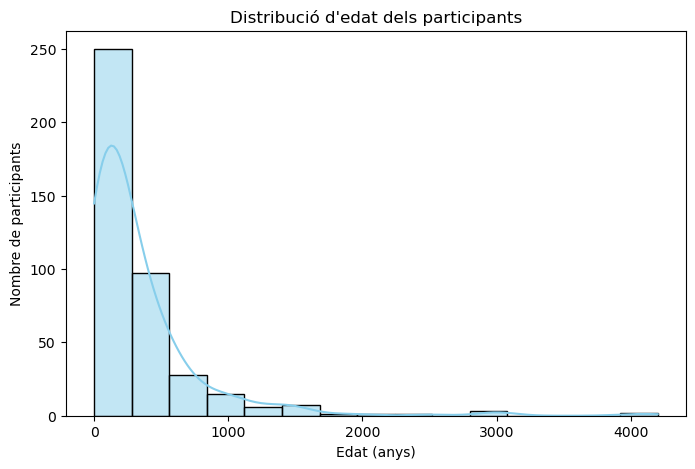

In [4]:
# plot per la distribució d'edat
print(stats.shapiro(df["assignacio_mensual"].dropna()))

plt.figure(figsize=(8, 5))
sns.histplot(df["assignacio_mensual"].dropna(), bins=15, kde=True, color="skyblue")
plt.title("Distribució d'edat dels participants")
plt.xlabel("Edat (anys)")
plt.ylabel("Nombre de participants")
plt.show()


ShapiroResult(statistic=0.7140156894309608, pvalue=2.2862038364051936e-26)


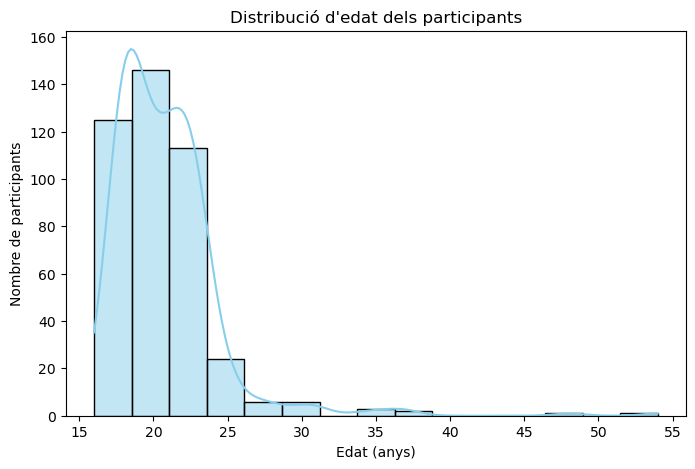

In [5]:
# plot per la distribució d'edat
print(stats.shapiro(df["edat"].dropna()))
plt.figure(figsize=(8, 5))
sns.histplot(df["edat"].dropna(), bins=15, kde=True, color="skyblue")
plt.title("Distribució d'edat dels participants")
plt.xlabel("Edat (anys)")
plt.ylabel("Nombre de participants")
plt.show()

***PREGUNTES LIKERT***

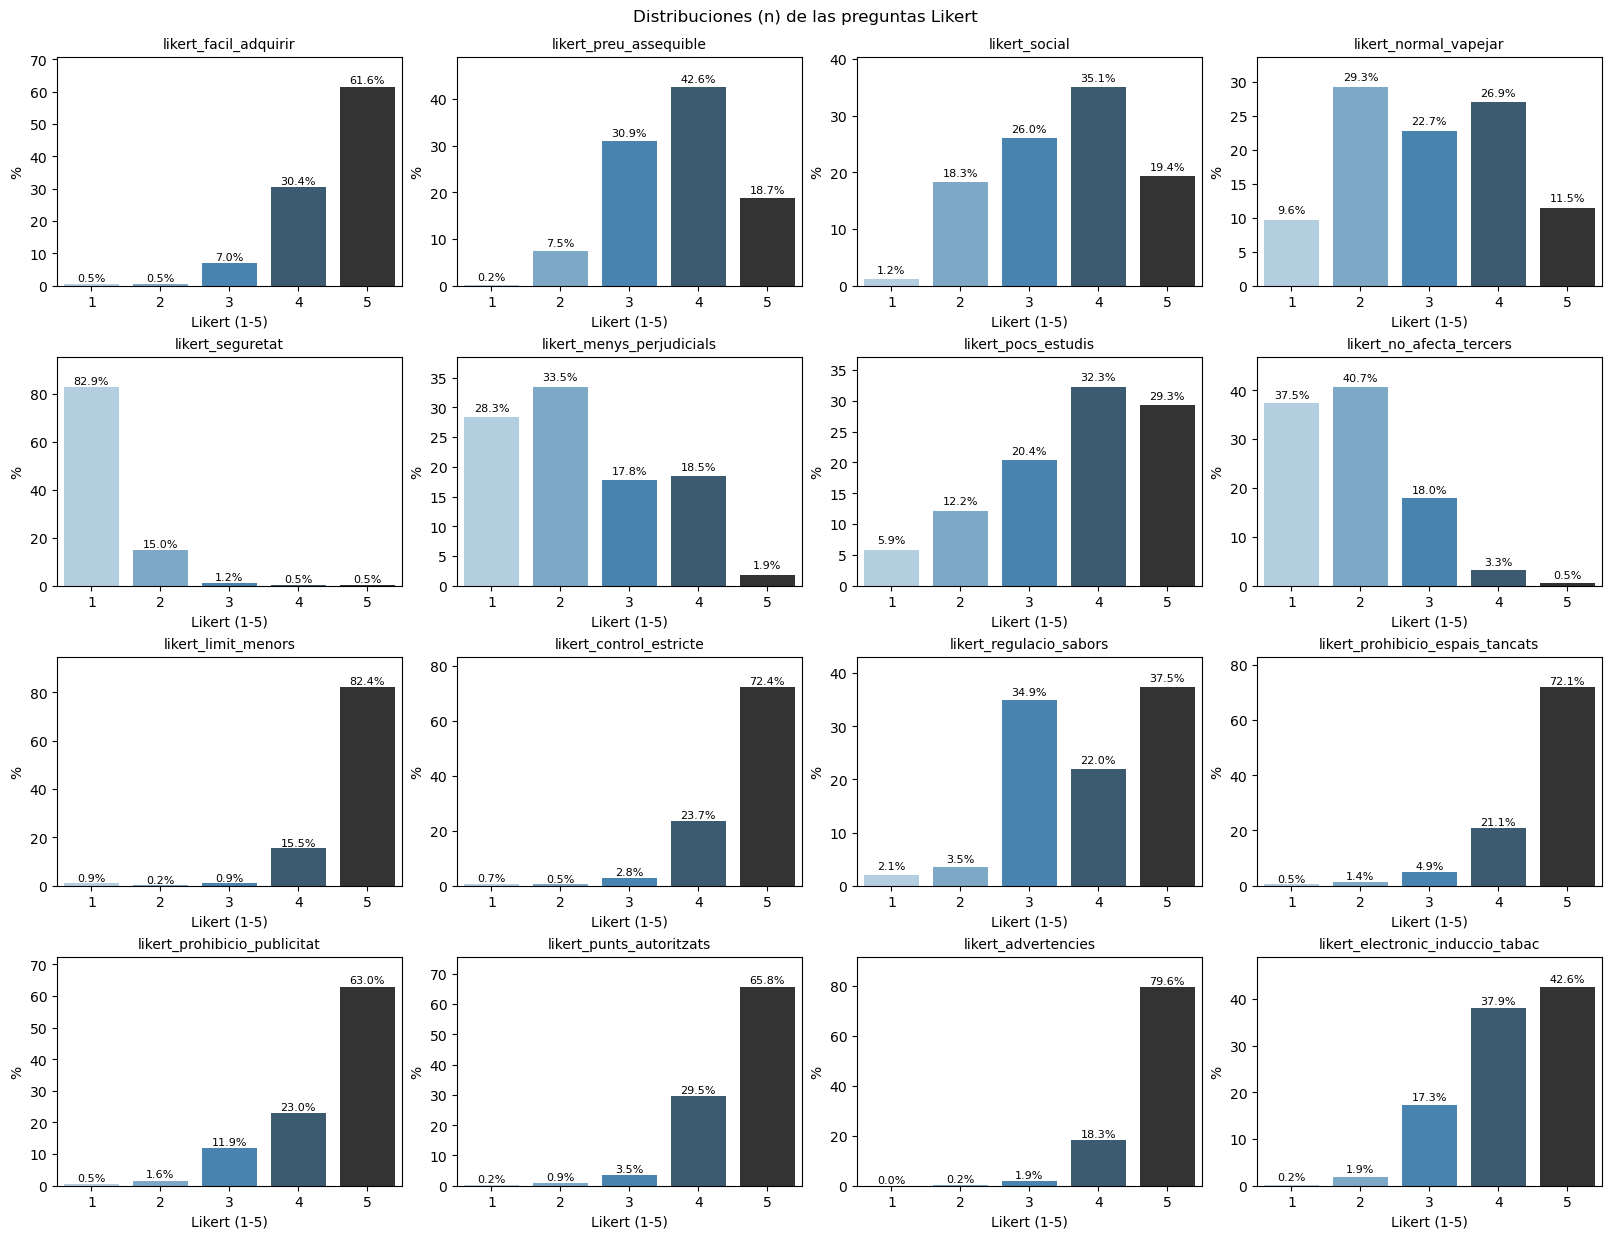

In [6]:
# Plots de barras con distribuciones y tabla resumen (media, mediana, IC 95%) para las columnas Likert
# 
# (counts: cantidades absolutas, perc: porcentaje respecto al total de respuestas válidas)


n_cols = 4
n_rows = int(np.ceil(len(likert_columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), constrained_layout=True)
axes = axes.flatten()

summary_rows = []
for i, col in enumerate(likert_columns):
    ax = axes[i]
    # Asegurar serie numérica y filtrar NaNs
    series = pd.to_numeric(df[col], errors="coerce").dropna().astype(int)
    counts = series.value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)
    perc = counts / counts.sum() * 100

    # Barplot de porcentajes por categoría (1..5)
    sns.barplot(
        x=perc.index,
        y=perc.values,
        hue=perc.index,
        palette="Blues_d",
        ax=ax,
        legend=False
    )
    ax.set_title(col, fontsize=10)
    ax.set_xlabel("Likert (1-5)")
    ax.set_ylabel("%")
    ax.set_ylim(0, max(perc.values.max() * 1.15, 1))

    # Anotar porcentajes encima de cada barra
    for xi, val in enumerate(perc.values):
        ax.text(xi, val + 1.0, f"{val:.1f}%", ha="center", fontsize=8)

    # Estadísticos: n, media, mediana, IC 95% (t-student)
    n = int(series.count())
    mean = float(series.mean()) if n > 0 else np.nan
    median = float(series.median()) if n > 0 else np.nan

    if n > 1:
        se = stats.sem(series, nan_policy="omit")
        h = se * stats.t.ppf((1 + 0.95) / 2., n - 1)
        ci_low = mean - h
        ci_high = mean + h
    else:
        ci_low = np.nan
        ci_high = np.nan

    summary_rows.append({
        "column": col,
        "n": n,
        "mean": mean,
        "median": median,
        "ci95_low": ci_low,
        "ci95_high": ci_high
    })

# Quitar ejes sobrantes si los hubiera
for j in range(len(likert_columns), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribuciones (n) de las preguntas Likert", y=1.02)
plt.show()

In [7]:
# Crear una copia de summary_df pero con el índice renombrado a las preguntas originales
# Invertir el mapeo original para recuperar las preguntas tal como estaban antes del rename
invert_map = {v: k for k, v in column_map.items()}

# Construir la tabla resumen
summary_df = pd.DataFrame(summary_rows).set_index("column")
summary_df = summary_df[["n", "mean", "median", "ci95_low", "ci95_high"]]

# Formateo para mostrar
summary_df = summary_df.round({"mean": 2, "median": 2, "ci95_low": 2, "ci95_high": 2})

# Copiar summary_df y reemplazar índices (nombres de columna renombrados) por la pregunta original
summary_df_preguntas = summary_df.copy()
summary_df_preguntas.index = [invert_map.get(idx, idx) for idx in summary_df_preguntas.index]
summary_df_preguntas.index.name = "pregunta"

display(summary_df_preguntas)

,n,mean,median,ci95_low,ci95_high
pregunta,,,,,
Les cigarretes electròniques són fàcils d’adquirir.,427,4.52,5.0,4.46,4.59
El seu preu és assequible per a la majoria dels joves.,427,3.72,4.0,3.64,3.80
Vapejar està socialment ben vist.,427,3.53,4.0,3.44,3.63
Considero que és normal veure companys vapejant en espais universitaris o socials.,427,3.01,3.0,2.90,3.13
Crec que les cigarretes electròniques són segures per a la salut.,427,1.21,1.0,1.16,1.26
Les considero menys perjudicials que el tabac convencional.,427,2.32,2.0,2.21,2.43
No hi ha prou estudis sobre els efectes adversos del vaping.,427,3.67,4.0,3.56,3.78
El vapor de les cigarretes electròniques no afecta a tercers.,427,1.89,2.0,1.80,1.97
S’hauria de limitar l’accés a menors.,427,4.78,5.0,4.73,4.84


In [8]:
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

# Columns to include
numeric_cols = [c for c in ["edat", "assignacio_mensual"] + likert_columns if c in df.columns]

# Convert to numeric
df_num = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Correlation matrix
corr = df_num.corr(method="pearson")

# -----------------------------
# BUILD ANNOTATION MATRIX (ONLY r, NO STARS)
# -----------------------------
annot_r = corr.round(2).astype(str)

# -----------------------------
# Compute p-values
# -----------------------------
pvals = pd.DataFrame(
    np.ones((len(numeric_cols), len(numeric_cols))),
    index=numeric_cols, columns=numeric_cols
)

for i, col_i in enumerate(numeric_cols):
    for j, col_j in enumerate(numeric_cols):
        if j <= i:
            continue
        paired = df_num[[col_i, col_j]].dropna()
        if len(paired) > 2:
            _, p = pearsonr(paired.iloc[:, 0], paired.iloc[:, 1])
            pvals.loc[col_i, col_j] = p
            pvals.loc[col_j, col_i] = p
        else:
            pvals.loc[col_i, col_j] = np.nan
            pvals.loc[col_j, col_i] = np.nan

# -----------------------------
# DISPLAY TABLES
# -----------------------------
print("📌 MATRIZ DE CORRELACIONES (r)")
display(corr.round(3))

print("📌 MATRIZ DE P-VALUES")
display(pvals.round(4))



📌 MATRIZ DE CORRELACIONES (r)


,edat,assignacio_mensual,likert_facil_adquirir,likert_preu_assequible,likert_social,likert_normal_vapejar,likert_seguretat,likert_menys_perjudicials,likert_pocs_estudis,likert_no_afecta_tercers,likert_limit_menors,likert_control_estricte,likert_regulacio_sabors,likert_prohibicio_espais_tancats,likert_prohibicio_publicitat,likert_punts_autoritzats,likert_advertencies,likert_electronic_induccio_tabac
edat,1.000,0.490,-0.071,-0.026,-0.061,-0.127,0.107,-0.010,-0.035,-0.016,0.026,-0.029,0.076,0.068,0.070,0.010,0.013,-0.017
assignacio_mensual,0.490,1.000,-0.037,0.113,-0.033,-0.001,0.081,0.099,-0.015,0.062,-0.043,-0.048,0.019,-0.063,-0.006,0.002,-0.043,0.069
likert_facil_adquirir,-0.071,-0.037,1.000,0.337,0.193,0.109,-0.019,0.016,0.177,-0.038,0.203,0.232,0.147,0.072,0.113,0.172,0.212,0.162
likert_preu_assequible,-0.026,0.113,0.337,1.000,0.206,0.025,-0.070,0.068,0.091,0.008,0.156,0.183,0.102,0.063,0.069,0.083,0.091,0.144
likert_social,-0.061,-0.033,0.193,0.206,1.000,0.291,-0.004,-0.036,0.119,-0.010,0.148,0.153,0.012,0.083,0.100,0.140,0.137,0.063
likert_normal_vapejar,-0.127,-0.001,0.109,0.025,0.291,1.000,0.117,0.079,0.058,0.081,0.057,0.003,-0.063,-0.045,-0.064,0.017,-0.032,0.051
likert_seguretat,0.107,0.081,-0.019,-0.070,-0.004,0.117,1.000,0.251,0.027,0.256,-0.279,-0.306,-0.134,-0.212,-0.162,-0.226,-0.208,-0.119
likert_menys_perjudicials,-0.010,0.099,0.016,0.068,-0.036,0.079,0.251,1.000,0.104,0.228,-0.115,-0.153,-0.143,-0.101,-0.077,-0.109,-0.178,-0.050
likert_pocs_estudis,-0.035,-0.015,0.177,0.091,0.119,0.058,0.027,0.104,1.000,0.039,0.110,0.132,0.027,0.043,-0.011,0.117,0.066,0.141
likert_no_afecta_tercers,-0.016,0.062,-0.038,0.008,-0.010,0.081,0.256,0.228,0.039,1.000,-0.166,-0.201,-0.215,-0.250,-0.118,-0.113,-0.233,-0.133


📌 MATRIZ DE P-VALUES


,edat,assignacio_mensual,likert_facil_adquirir,likert_preu_assequible,likert_social,likert_normal_vapejar,likert_seguretat,likert_menys_perjudicials,likert_pocs_estudis,likert_no_afecta_tercers,likert_limit_menors,likert_control_estricte,likert_regulacio_sabors,likert_prohibicio_espais_tancats,likert_prohibicio_publicitat,likert_punts_autoritzats,likert_advertencies,likert_electronic_induccio_tabac
edat,1.0000,0.0000,0.1421,0.5931,0.2097,0.0088,0.0275,0.8380,0.4658,0.7373,0.5856,0.5524,0.1186,0.1597,0.1499,0.8291,0.7896,0.7322
assignacio_mensual,0.0000,1.0000,0.4532,0.0221,0.5014,0.9848,0.1012,0.0443,0.7660,0.2064,0.3872,0.3304,0.7004,0.1990,0.8989,0.9641,0.3851,0.1619
likert_facil_adquirir,0.1421,0.4532,1.0000,0.0000,0.0001,0.0248,0.6907,0.7343,0.0002,0.4355,0.0000,0.0000,0.0024,0.1383,0.0197,0.0004,0.0000,0.0008
likert_preu_assequible,0.5931,0.0221,0.0000,1.0000,0.0000,0.6134,0.1462,0.1597,0.0593,0.8764,0.0013,0.0001,0.0354,0.1918,0.1572,0.0883,0.0596,0.0028
likert_social,0.2097,0.5014,0.0001,0.0000,1.0000,0.0000,0.9296,0.4524,0.0139,0.8327,0.0022,0.0015,0.7997,0.0849,0.0398,0.0038,0.0047,0.1944
likert_normal_vapejar,0.0088,0.9848,0.0248,0.6134,0.0000,1.0000,0.0158,0.1025,0.2286,0.0944,0.2369,0.9476,0.1966,0.3495,0.1898,0.7257,0.5140,0.2953
likert_seguretat,0.0275,0.1012,0.6907,0.1462,0.9296,0.0158,1.0000,0.0000,0.5807,0.0000,0.0000,0.0000,0.0054,0.0000,0.0008,0.0000,0.0000,0.0140
likert_menys_perjudicials,0.8380,0.0443,0.7343,0.1597,0.4524,0.1025,0.0000,1.0000,0.0315,0.0000,0.0170,0.0015,0.0030,0.0372,0.1137,0.0248,0.0002,0.2990
likert_pocs_estudis,0.4658,0.7660,0.0002,0.0593,0.0139,0.2286,0.5807,0.0315,1.0000,0.4174,0.0228,0.0063,0.5813,0.3788,0.8143,0.0155,0.1715,0.0036
likert_no_afecta_tercers,0.7373,0.2064,0.4355,0.8764,0.8327,0.0944,0.0000,0.0000,0.4174,1.0000,0.0006,0.0000,0.0000,0.0000,0.0143,0.0191,0.0000,0.0059


*CORRELACION ENTRE SER FUMADOR/EXFUMADOR/NO FUMADOR Y VARIABLES COMO LA EDAD, EL SEXO, EL CURSO O LA ASIGNACION MENSUAL*

In [9]:
df["sexe_assignat"] = df["sexe_assignat"].map({
    "Home": 0,
    "Dona": 1
})

df["coneix_diferencia_iqos_vaper"] = df["coneix_diferencia_iqos_vaper"].map({
    "No": 0,
    "Sí": 1
})

df["curs"] = df["curs"].map({
    "1r": 1,
    "2n": 2,
    "3r": 3,
    "4t": 4,
    "5è": 5,
    "6è": 6
})

fumador_vars = ["fumador", "no_fumador", "exfumador"]
vars_cuant = ["edat", "sexe_assignat", "curs", "assignacio_mensual"]

# ------------------------------------------------------
# 3. CÁLCULO AUTOMÁTICO DE CORRELACIONES
# ------------------------------------------------------

resultados = []

for fum_var in fumador_vars:
    for v in vars_cuant:

        # Filtrar filas sin NaN
        df_temp = df[[fum_var, v]].dropna()

        if len(df_temp) < 2:  # no se puede correlacionar
            corr = np.nan
            p = np.nan
        else:
            corr, p = pearsonr(df_temp[fum_var], df_temp[v])

        resultados.append({
            "variable_fumador": fum_var,
            "variable_continua": v,
            "correlacion": corr,
            "p_valor": p
        })

# Convertir a DataFrame final
tabla_cor = pd.DataFrame(resultados).round(4)

# Mostrar tabla
tabla_cor

,variable_fumador,variable_continua,correlacion,p_valor
0,fumador,edat,-0.0031,0.9489
1,fumador,sexe_assignat,-0.0363,0.4542
2,fumador,curs,0.0639,0.1877
3,fumador,assignacio_mensual,0.1486,0.0025
4,no_fumador,edat,-0.0530,0.2745
5,no_fumador,sexe_assignat,0.0134,0.7830
6,no_fumador,curs,0.0015,0.9753
7,no_fumador,assignacio_mensual,-0.0872,0.0773
8,exfumador,edat,0.0607,0.2106
9,exfumador,sexe_assignat,0.0068,0.8880


*CORRELACION ENTRE SER FUMADOR/EXFUMADOR/NO FUMADOR CON TODAS LAS PREGUNTAS LIKERT*

In [10]:
fumador_vars = ["fumador", "no_fumador", "exfumador"]

resultados = []

for l_col in likert_columns:
    for f_col in fumador_vars:

        data = df[[l_col, f_col]].dropna()

        # Evitar errores si no hay datos suficientes
        if len(data) < 3:
            corr = np.nan
            p = np.nan
        else:
            corr, p = pearsonr(data[l_col], data[f_col])

        resultados.append({
            "likert": l_col,
            "variable_fumador": f_col,
            "correlacion_r": corr,
            "p_valor": p
        })

tabla_cor_likert = pd.DataFrame(resultados).round(4)

tabla_cor_likert.sort_values("p_valor")

,likert,variable_fumador,correlacion_r,p_valor
33,likert_prohibicio_espais_tancats,fumador,-0.1983,0.0000
34,likert_prohibicio_espais_tancats,no_fumador,0.2401,0.0000
35,likert_prohibicio_espais_tancats,exfumador,-0.1482,0.0021
25,likert_limit_menors,no_fumador,0.1213,0.0121
9,likert_normal_vapejar,fumador,0.1045,0.0309
28,likert_control_estricte,no_fumador,0.1019,0.0353
15,likert_menys_perjudicials,fumador,0.0936,0.0534
6,likert_social,fumador,-0.0895,0.0648
26,likert_limit_menors,exfumador,-0.0873,0.0715
19,likert_pocs_estudis,no_fumador,-0.0836,0.0844


*CORRELACION LIKERT CON PREGUNTA DEL CONOCIMIENTO DE DIFERENCIAS DEL TABACO Y EL VAPER*

In [11]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

binaria = "coneix_diferencia_iqos_vaper"

resultados = []

for col in likert_columns:

    datos = df[[col, binaria]].dropna()

    if len(datos) < 3:
        r = np.nan
        p = np.nan
    else:
        r, p = pearsonr(datos[col], datos[binaria])

    resultados.append({
        "likert": col,
        "correlacion_r": r,
        "p_valor": p
    })

tabla_cor_iqos = pd.DataFrame(resultados).round(4)

tabla_cor_iqos.sort_values("p_valor")



,likert,correlacion_r,p_valor
11,likert_prohibicio_espais_tancats,-0.1270,0.0086
0,likert_facil_adquirir,0.1239,0.0104
1,likert_preu_assequible,0.1167,0.0158
15,likert_electronic_induccio_tabac,0.1085,0.0249
3,likert_normal_vapejar,0.0819,0.0910
2,likert_social,-0.0646,0.1827
10,likert_regulacio_sabors,0.0436,0.3685
7,likert_no_afecta_tercers,0.0373,0.4417
5,likert_menys_perjudicials,-0.0242,0.6175
8,likert_limit_menors,-0.0152,0.7547


In [12]:
likert_columns_ambiguas = ['likert_social', 'likert_normal_vapejar', 'likert_menys_perjudicials', 'likert_pocs_estudis']
likert_columnas_no_ambiguas = [col for col in likert_columns if col not in likert_columns_ambiguas]
likert_ambiguas = df[likert_columns_ambiguas]
likert_no_ambiguas = df[likert_columnas_no_ambiguas]

In [13]:
df.columns.to_list()

['edat',
 'sexe_assignat',
 'genere',
 'pais_naixement',
 'curs',
 'assignacio_mensual',
 'subs_30dies',
 'coneix_diferencia_iqos_vaper',
 'primera_cigarreta_minuts',
 'cigarretes_dia',
 'ambits_consum',
 'edat_inici_conventional',
 'edat_inici_vaper',
 'edat_inici_iqos',
 'motiu_inici_vaper',
 'motiu_inici_iqos',
 'amics_fumen',
 'likert_facil_adquirir',
 'likert_preu_assequible',
 'likert_social',
 'likert_normal_vapejar',
 'likert_seguretat',
 'likert_menys_perjudicials',
 'likert_pocs_estudis',
 'likert_no_afecta_tercers',
 'likert_limit_menors',
 'likert_control_estricte',
 'likert_regulacio_sabors',
 'likert_prohibicio_espais_tancats',
 'likert_prohibicio_publicitat',
 'likert_punts_autoritzats',
 'likert_advertencies',
 'likert_electronic_induccio_tabac',
 'consum_Alcohol',
 'consum_Altres',
 'consum_Amfetamines',
 'consum_Cap',
 'consum_Cigarretes electròniques',
 'consum_Cànnabis',
 'consum_Estimulants',
 'consum_Productes de tabac per escalfament (tipus IQOS)',
 'consum_Tabac

In [14]:
df["cigarretes_dia"].to_list()

[nan,
 nan,
 nan,
 nan,
 nan,
 'No fumo',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'No fumo',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '10 o menys ',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '10 o menys ',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '10 o menys ',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '10 o menys ',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 '10 o menys ',
 '10 o menys ',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

*FAGERSTROM Y CORRELACION CON LIKERT*

In [15]:
import numpy as np
import pandas as pd

# ---------------------------
# Mapeo para "primera_cigarreta_minuts"
# ---------------------------

map_primera = {
    '6-30 minuts': 2,
    '31-60 minuts': 1,
    ' Més de 60 minuts': 0,
    "No fumo": np.nan,
    "no fumo": np.nan
}

df["puntos_primera"] = df["primera_cigarreta_minuts"].map(map_primera)


# ---------------------------
# Mapeo para "cigarretes_dia"
# ---------------------------

map_cigs = {
    "10 o menys ": 0,
    "11-20 ": 1,
    "No fumo": np.nan,
    "no fumo": np.nan
}

df["puntos_dia"] = df["cigarretes_dia"].map(map_cigs)


# ---------------------------
# Puntuación total del Fagerström breve
# ---------------------------
df["fagerstrom"] = df["puntos_primera"] + df["puntos_dia"]

print(df["fagerstrom"].value_counts(dropna=False).sort_index())

# Correlacion entre fagerstrom y likert
resultados = []

for col in likert_columns:
    datos = df[[col, "fagerstrom"]].dropna()

    if len(datos) < 3:
        r = np.nan
        p = np.nan
    else:
        r, p = pearsonr(datos[col], datos["fagerstrom"])

    resultados.append({
        "likert": col,
        "correlacion_r": r,
        "p_valor": p
    })
tabla_cor_fagerstrom = pd.DataFrame(resultados).round(4)
tabla_cor_fagerstrom.sort_values("p_valor")
tabla_cor_fagerstrom
tabla_cor_fagerstrom.sort_values("p_valor")

fagerstrom
0.0     12
1.0      5
2.0      1
3.0      1
NaN    408
Name: count, dtype: int64


,likert,correlacion_r,p_valor
5,likert_menys_perjudicials,0.5010,0.0289
12,likert_prohibicio_publicitat,0.4568,0.0493
10,likert_regulacio_sabors,0.3655,0.1238
3,likert_normal_vapejar,-0.3521,0.1393
8,likert_limit_menors,0.3066,0.2017
13,likert_punts_autoritzats,0.3035,0.2065
2,likert_social,-0.2981,0.2151
7,likert_no_afecta_tercers,0.2390,0.3245
11,likert_prohibicio_espais_tancats,0.1836,0.4517
9,likert_control_estricte,0.1512,0.5367


In [16]:
# Verificar cuantas personas no se han identificado como fumadores, pero en los ultimos 30 dias han probado el tabaco o el vaper
df_fumadores_30dias = df[
    (df["fumador"] == 0) & 
    (
        (df["consum_Tabac convencional"] == 1) | 
        (df["consum_Cigarretes electròniques"] == 1) | 
        (df["consum_Productes de tabac per escalfament (tipus IQOS)"] == 1)
    )
]
print(f"Personas no identificadas como fumadores pero que han consumido tabaco o vaper en los últimos 30 días: {len(df_fumadores_30dias)}")

Personas no identificadas como fumadores pero que han consumido tabaco o vaper en los últimos 30 días: 49


In [17]:
# Verificar dentro de los fumadores, cuantos han consumido tabaco convencional, vaper o IQOS en los últimos 30 días
df_fumadores = df[df["fumador"] == 1]
consumo_fumadores = {
    "Tabac convencional": df_fumadores["consum_Tabac convencional"].sum(),
    "Cigarretes electròniques": df_fumadores["consum_Cigarretes electròniques"].sum(),
    "Productes de tabac per escalfament (tipus IQOS)": df_fumadores["consum_Productes de tabac per escalfament (tipus IQOS)"].sum()
}
print("Consumo entre fumadores identificados:")
for producto, cantidad in consumo_fumadores.items():
    print(f"- {producto}: {cantidad}")


Consumo entre fumadores identificados:
- Tabac convencional: 21
- Cigarretes electròniques: 10
- Productes de tabac per escalfament (tipus IQOS): 9


In [18]:
# TABLA QUE MUESTRE LA N Y EL % QUE HAN CONSUMIDO CADA SUSTANCIA EN LOS ÚLTIMOS 30 DÍAS
total_participantes = len(df)
consumo_substancias = {}
for substance in all_substances:
    count = df[f"consum_{substance}"].sum()
    percentage = (count / total_participantes) * 100
    consumo_substancias[substance] = {
        "n": count,
        "%": f"{percentage:.1f}%"
    }
consumo_substancias_df = pd.DataFrame.from_dict(consumo_substancias, orient="index")
consumo_substancias_df.sort_values("n", ascending=False, inplace=True)
print("Consumo de sustancias en los últimos 30 días:")
display(consumo_substancias_df)

Consumo de sustancias en los últimos 30 días:


,n,%
Alcohol,287,67.2%
Cap,133,31.1%
Tabac convencional,59,13.8%
Cigarretes electròniques,31,7.3%
Productes de tabac per escalfament (tipus IQOS),20,4.7%
Cànnabis,11,2.6%
Altres,5,1.2%
Amfetamines,2,0.5%
Estimulants,2,0.5%


In [19]:
# TABLA QUE MUESTRE LA N Y EL % de fumadores, exfumadores y no fumadores
total_participantes = len(df)
estado_fumador = {
    "Fumador": df["fumador"].sum(),
    "Exfumador": df["exfumador"].sum(),
    "No fumador": df["no_fumador"].sum()
}
estado_fumador_df = pd.DataFrame.from_dict(estado_fumador, orient="index", columns=["n"])
estado_fumador_df["%"] = (estado_fumador_df["n"] / total_participantes * 100).round(1).astype(str) + "%"
print("Estado de fumador entre los participantes:")
display(estado_fumador_df)



Estado de fumador entre los participantes:


,n,%
Fumador,22,5.2%
Exfumador,70,16.4%
No fumador,335,78.5%


In [20]:
def categoria_fagerstrom(x):
    if pd.isna(x):
        return np.nan
    if x <= 2:
        return "Dependència baixa"
    elif 3 <= x <= 4:
        return "Dependència moderada"
    else:
        return "Dependència elevada"

df["fagerstrom_categoria"] = df["fagerstrom"].apply(categoria_fagerstrom)

# Filtrar solo fumadores de tabac convencional
df_fum = df[df["fumador"] == 1]

# Conteo n
conteo = df_fum["fagerstrom_categoria"].value_counts(dropna=True)

# Porcentajes
porcentaje = df_fum["fagerstrom_categoria"].value_counts(normalize=True) * 100

# Combinar en una tabla
tabla_fagerstrom = pd.DataFrame({
    "n": conteo,
    "%": porcentaje.round(1)
})

tabla_fagerstrom



,n,%
fagerstrom_categoria,,
Dependència baixa,18,94.7
Dependència moderada,1,5.3


In [21]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

tabla = pd.crosstab(df["sexe_assignat"], df["consum_Cigarretes electròniques"])
print(tabla)


consum_Cigarretes electròniques    0   1
sexe_assignat                           
0                                114  11
1                                282  20


In [22]:
chi2, p, dof, expected = chi2_contingency(tabla)

print("Frecuencias esperadas:")
print(expected)


Frecuencias esperadas:
[[115.92505855   9.07494145]
 [280.07494145  21.92505855]]


In [23]:
chi2, p, dof, expected = chi2_contingency(tabla)

print("Chi-quadrado:", chi2)
print("p-valor:", p)


Chi-quadrado: 0.3411734321424025
p-valor: 0.5591526765387419


In [24]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# ============================================================
# 0. CONFIGURACIÓN: AJUSTA ESTOS NOMBRES A TU DATASET
# ============================================================

# Variables cuantitativas que quieres comparar entre grupos
quant_vars = [
    "edat",
    "assignacio_mensual",
    # añade aquí otras cuantitativas (p.ej. puntuaciones likert si las tratas como escala)
    # "fagerstrom",
]

# Variable binaria de consumo de vaper (0 = no, 1 = sí)
# Cambia el nombre si en tu df se llama distinto (p.ej. "consum_Cigarretes electròniques")

df = df.rename(columns={
    "consum_Cigarretes electròniques": "consum_Cigarretes_electroniques"
})


vaper_var = "consum_Cigarretes_electroniques"

# Otras variables categóricas con las que quieras cruzar (para chi-quadrat / Fisher)
cat_pairs = [
    ("sexe_assignat", vaper_var),
    ("genere", vaper_var),
    ("curs", vaper_var),
    # añade aquí lo que necesites, por ejemplo:
    # ("consum_tabac_convencional", vaper_var),
    # ("consum_cannabis", vaper_var),
]

# Para la regresión logística:
#   - Dependent variable: consumo de vaper (0/1)
#   - Predictoras: ajusta según tu interés y lo que tengas
logit_outcome = vaper_var
logit_predictors = [
    "edat",
    "sexe_assignat",
    "curs",
    "assignacio_mensual",
    # añade aquí consumo de tabac, alcohol, cànnabis, etc. si las tienes
    # "consum_tabac_convencional",
    # "consum_cannabis",
    # "consum_alcohol",
]

# ============================================================
# 1. TEST DE NORMALIDAD (Shapiro–Wilk) PARA VARIABLES CUANTITATIVAS
# ============================================================

normality_results = []

for var in quant_vars:
    series = df[var].dropna()
    if len(series) >= 3:
        stat, p = stats.shapiro(series)
    else:
        stat, p = np.nan, np.nan
    
    normality_results.append({
        "variable": var,
        "n": len(series),
        "shapiro_W": stat,
        "p_valor": p,
        "distribucion": "normal" if (p is not np.nan and p >= 0.05) else "no_normal"
    })

normality_df = pd.DataFrame(normality_results)
print("🔎 TEST DE NORMALIDAD (Shapiro–Wilk)")
display(normality_df)

# Convertimos a diccionario para consultarlo luego
normality_dict = dict(zip(normality_df["variable"], normality_df["distribucion"]))


# ============================================================
# 2. COMPARACIÓN DE VARIABLES CUANTITATIVAS SEGÚN CONSUMO DE VAPER
#    (t de Student o Mann–Whitney U)
# ============================================================

comparaciones = []

# Nos aseguramos de que la variable vaper sea 0/1
# (si no lo está, aquí podrías mapear sus valores a 0/1 antes)
for var in quant_vars:
    sub = df[[vaper_var, var]].dropna()
    if sub[vaper_var].nunique() != 2:
        continue  # hace falta que sea binaria

    grupo0 = sub[sub[vaper_var] == 0][var]
    grupo1 = sub[sub[vaper_var] == 1][var]

    # Por simplicidad usamos la decisión global de normalidad de la variable
    dist = normality_dict.get(var, "no_normal")

    if dist == "normal" and len(grupo0) >= 3 and len(grupo1) >= 3:
        test = "t_student"
        stat, p = stats.ttest_ind(grupo0, grupo1, equal_var=False, nan_policy="omit")
    else:
        test = "mann_whitney"
        stat, p = stats.mannwhitneyu(grupo0, grupo1, alternative="two-sided")

    comparaciones.append({
        "variable": var,
        "test": test,
        "n_grupo0": len(grupo0),
        "n_grupo1": len(grupo1),
        "estadistico": stat,
        "p_valor": p
    })

comparaciones_df = pd.DataFrame(comparaciones)
print("📊 COMPARACIÓN DE VARIABLES CUANTITATIVAS SEGÚN CONSUMO DE VAPER")
display(comparaciones_df.round(4))


# ============================================================
# 3. ASOCIACIÓN ENTRE VARIABLES CUALITATIVAS:
#    CHI-QUADRAT O FISHER AUTOMÁTICAMENTE
# ============================================================

def chi2_o_fisher(df, var1, var2):
    tabla = pd.crosstab(df[var1], df[var2])
    chi2, p_chi2, dof, expected = stats.chi2_contingency(tabla)

    usa_fisher = (expected < 5).sum() > 0 and tabla.shape == (2, 2)

    if usa_fisher:
        test = "fisher"
        or_val, p = stats.fisher_exact(tabla)
        return {
            "test": test,
            "chi2": np.nan,
            "OR": or_val,
            "p_valor": p,
            "tabla": tabla,
            "expected": expected
        }
    else:
        test = "chi_quadrat"
        return {
            "test": test,
            "chi2": chi2,
            "OR": np.nan,
            "p_valor": p_chi2,
            "tabla": tabla,
            "expected": expected
        }

resultats_cat = []

for v1, v2 in cat_pairs:
    sub = df[[v1, v2]].dropna()
    if sub.empty:
        continue

    res = chi2_o_fisher(sub, v1, v2)
    resultats_cat.append({
        "var1": v1,
        "var2": v2,
        "test": res["test"],
        "chi2": res["chi2"],
        "OR_si_fisher": res["OR"],
        "p_valor": res["p_valor"]
    })

chi_fisher_df = pd.DataFrame(resultats_cat)
print("🔗 ASSOCIACIÓ ENTRE VARIABLES CATEGÒRIQUES (χ² / Fisher)")
display(chi_fisher_df.round(4))


# ============================================================
# 4. MODEL MULTIVARIAT DE REGRESSIÓ LOGÍSTICA
#    PER AL CONSUM DE VÀPERS (OR + IC95%)
# ============================================================

# Construimos la fórmula tipo: outcome ~ x1 + x2 + ...
predictors_str = " + ".join(logit_predictors)
formula = f"{logit_outcome} ~ {predictors_str}"
print("📌 Fórmula logística usada:")
print(formula)

# Eliminamos NaNs en las variables implicadas
vars_model = [logit_outcome] + logit_predictors
df_model = df[vars_model].dropna()

# Ajuste del modelo
logit_model = smf.logit(formula, data=df_model).fit()
print(logit_model.summary())

# OR + IC95%
params = logit_model.params
conf = logit_model.conf_int()
or_table = pd.DataFrame({
    "OR": np.exp(params),
    "IC95_inf": np.exp(conf[0]),
    "IC95_sup": np.exp(conf[1]),
    "p_valor": logit_model.pvalues
})

print("📌 ODDS RATIO (OR) I INTERVALS DE CONFIANÇA (95%)")
display(or_table.round(4))


🔎 TEST DE NORMALIDAD (Shapiro–Wilk)


,variable,n,shapiro_W,p_valor,distribucion
0,edat,427,0.714016,2.286204e-26,no_normal
1,assignacio_mensual,411,0.601530,1.158217e-29,no_normal


📊 COMPARACIÓN DE VARIABLES CUANTITATIVAS SEGÚN CONSUMO DE VAPER


,variable,test,n_grupo0,n_grupo1,estadistico,p_valor
0,edat,mann_whitney,396,31,7571.0,0.0286
1,assignacio_mensual,mann_whitney,380,31,5051.0,0.1858


🔗 ASSOCIACIÓ ENTRE VARIABLES CATEGÒRIQUES (χ² / Fisher)


,var1,var2,test,chi2,OR_si_fisher,p_valor
0,sexe_assignat,consum_Cigarretes_electroniques,chi_quadrat,0.3412,NaN,0.5592
1,genere,consum_Cigarretes_electroniques,chi_quadrat,0.8564,NaN,0.6517
2,curs,consum_Cigarretes_electroniques,chi_quadrat,5.2176,NaN,0.3899


📌 Fórmula logística usada:
consum_Cigarretes_electroniques ~ edat + sexe_assignat + curs + assignacio_mensual
Optimization terminated successfully.
         Current function value: 0.254392
         Iterations 8
                                  Logit Regression Results                                 
Dep. Variable:     consum_Cigarretes_electroniques   No. Observations:                  411
Model:                                       Logit   Df Residuals:                      406
Method:                                        MLE   Df Model:                            4
Date:                             Fri, 05 Dec 2025   Pseudo R-squ.:                 0.04883
Time:                                     01:47:39   Log-Likelihood:                -104.56
converged:                                    True   LL-Null:                       -109.92
Covariance Type:                         nonrobust   LLR p-value:                   0.02970
                         coef    std err          z 

,OR,IC95_inf,IC95_sup,p_valor
Intercept,52.9033,0.1502,18628.8977,0.1847
edat,0.7006,0.4964,0.9888,0.0430
sexe_assignat,0.7340,0.3355,1.6059,0.4388
curs,1.2435,0.8385,1.8442,0.2784
assignacio_mensual,1.0008,1.0001,1.0015,0.0291
